# Post Processing

This notebook is used to post process submissions. It's divided into 5 majors steps :
1. Extract automatically all archives from the input directory.
2. Convert all denses point cloud files (`.las` or `.laz`) into DEMs with `point2dem` command from ASP.
3. Coregister DEMs with references DEMs. And compute difference between coregistered DEMs and references DEMs.
4. Compute some global statistics on all the Post Processing.
5. Generate some plots.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import history
from pathlib import Path
import pandas as pd
from prefect.task_runners import ConcurrentTaskRunner

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings and Paths Managing

For the post Preprocessing workflow their is a lot of directory and paths. To simplify it, let's used the class `history.postprocessing.PathsManager`. 

In [3]:
raw_dir = "/mnt/summer/USERS/DEHECQA/history/output/raw"
extracted_dir = "/mnt/summer/USERS/DEHECQA/history/output/extracted"
processing_dir = "/mnt/summer/USERS/DEHECQA/history/output/new_processing" 
plots_dir = "/mnt/summer/USERS/DEHECQA/history/output/plots" 

# other settings
OVERWRITE = False
DRY_RUN = False # set this to True to avoid process
MAX_WORKERS = 4
VERBOSE = True
PDAL_EXEC_PATH = "/home/godinlu/micromamba/envs/pdal/bin/pdal"

task_runner = ConcurrentTaskRunner(max_workers=MAX_WORKERS)


In [ ]:
proc_dir = history.postprocessing.ProcessingDirectory(processing_dir)
print(proc_dir)

/mnt/summer/USERS/DEHECQA/history/output/to_del: Empty


In [9]:
%%capture

history.postprocessing.batch.uncompress_all_submissions.with_options(task_runner=task_runner)(raw_dir, extracted_dir, OVERWRITE)

In [20]:
%%capture

history.postprocessing.batch.run_postprocessing.with_options(task_runner=task_runner)(extracted_dir, processing_dir, PDAL_EXEC_PATH, dry_run=DRY_RUN)


In [22]:
%%capture

history.postprocessing.batch.generate_postprocessing_plots.with_options(task_runner=task_runner)(processing_dir, plots_dir)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
path_stats = "/mnt/summer/USERS/DEHECQA/history/output/new_processing/casa_grande/aerial/statistics.csv"
path_lc = "/mnt/summer/USERS/DEHECQA/history/output/new_processing/casa_grande/aerial/landcover_statistics.csv"
stats = pd.read_csv(path_stats, index_col="code")
lc_stats = pd.read_csv(path_lc)
inlier_codes = stats.index[stats["inliers"]]
lc_stats_inliers = lc_stats[lc_stats["code"].isin(inlier_codes)]
history.postprocessing.visualization.generate_coregistration_individual_plots(stats , "test")


[autoreload of history.postprocessing.batch failed: Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/godinlu/github/history/src/histo

In [14]:
stats.iloc[5]

pointcloud_file            /mnt/summer/USERS/DEHECQA/history/output/new_p...
raw_dem_file               /mnt/summer/USERS/DEHECQA/history/output/new_p...
coreg_dem_file             /mnt/summer/USERS/DEHECQA/history/output/new_p...
ddem_before_file           /mnt/summer/USERS/DEHECQA/history/output/new_p...
ddem_after_file            /mnt/summer/USERS/DEHECQA/history/output/new_p...
                                                 ...                        
pointcloud_bounds_z_max                                                822.0
coreg_shift_x                                                      -0.059794
coreg_shift_y                                                       5.387765
coreg_shift_z                                                       0.231018
inliers                                                                 True
Name: ESM_CG_AI_PP_CN_GY_PN_MN, Length: 73, dtype: object

In [6]:
base_dir = "/mnt/summer/USERS/DEHECQA/history/output/new_processing/casa_grande/aerial/"
Path(base_dir).parent.name

'casa_grande'

<Axes: xlabel='code'>

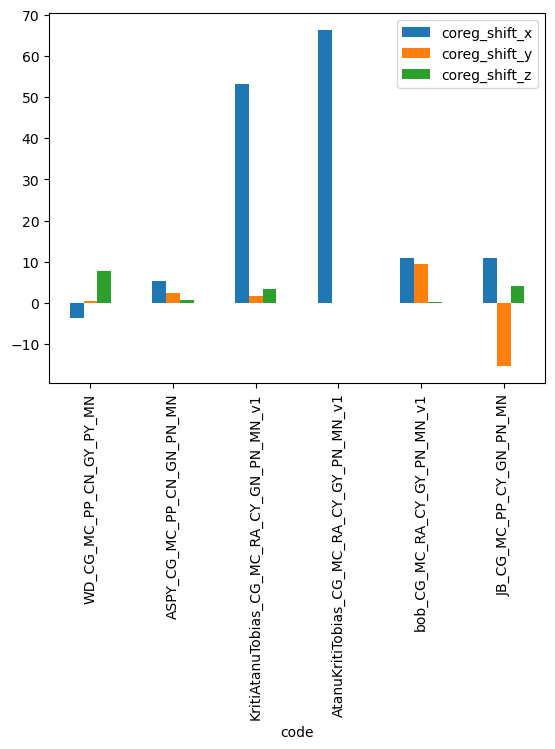

In [48]:
colnames = ["coreg_shift_x", "coreg_shift_y", "coreg_shift_z"]

df[colnames].plot(kind="bar")

In [33]:
df[["model1"]]

,model1
category,
A,10
B,15
C,8


In [26]:
df_long = df.melt(id_vars="category", var_name="model", value_name="value")
print(df_long)

  category   model  value
0        A  model1     10
1        B  model1     15
2        C  model1      8
3        A  model2     12
4        B  model2     18
5        C  model2      6
6        A  model3      9
7        B  model3     14
8        C  model3     10


## Step 1 : extract submissions

## Visualize Post Processing files

In [ ]:
viz.plot_files_recap(paths_manager)

## Step 2: Convert Dense Point Cloud Files into DEMs

This step processes **dense point cloud files** to generate DEMs that are spatially aligned with their corresponding reference DEMs.

- **Input search**: Point cloud files are searched **recursively** in the directory `extracted_submissions_dir` using the pattern `*_dense_pointcloud.{las,laz}`.  
- **Output location**: The resulting DEMs are saved in the directory `raw_dems_dir`.  
- **Reference selection**: For each point cloud file, the appropriate reference DEM is selected based on its `site` and `dataset` metadata.  

**Note:**  
The method `iter_point2dem` launches the ASP `point2dem` command with the parameters:  
- `max_concurrent_commands`: Maximum number of parallel `point2dem` processes.  
- `max_threads_per_command`: Maximum number of threads allocated to each individual process.  


In [ ]:
history.postprocessing.iter_convert_pointcloud_to_dem.with_options(task_runner=task_runner)(paths_manager, OVERWRITE, PDAL_EXEC_PATH, DRY_RUN)

## Step 3: Coregister DEMs

Coregister multiple DEMs in a directory to appropriate reference DEMs and return summary statistics.

This function iterates over all DEM files in `input_directory` ending with '-DEM.tif', 
selects the appropriate reference DEM and mask based on the site and dataset information,
and applies coregistration using the `coregister_dem` function. 

Coregistered DEMs are saved to `output_directory`. If `overwrite` is False, existing output files are skipped.
If `dry_run` is True, no coregistration is performed, only file names and planned operations are printed.

In [ ]:
history.postprocessing.iter_coregister_dems.with_options(task_runner=task_runner)(paths_manager, OVERWRITE)

## Step 4: Compute statistics

In [ ]:
# compute all statistics
global_statistics = history.postprocessing.compute_global_statistics(paths_manager)

In [ ]:
landcover_statistics = history.postprocessing.compute_landcover_statistics(paths_manager)

In [ ]:
history.postprocessing.batch.compute_std_dems_statistics.with_options(task_runner=task_runner)(paths_manager)

## Step 5 : Generate plots



In [ ]:
history.postprocessing.batch.generate_postprocessing_plots.with_options(task_runner=task_runner)(paths_manager)

In [ ]:
global_statistics_path = paths_manager.get_path("processing_dir") / "postprocessing_statistics.csv"
landcover_statistics_path = paths_manager.get_path("processing_dir") / "landcover_statistics.csv"

plot_dirs = {"all": paths_manager.get_path("processing_dir") / "plots", "inliers": paths_manager.get_path("processing_dir") / "plots_inliers"}

stat = pd.read_csv(global_statistics_path, index_col="code")
stat_inliers = stat.loc[stat["inliers"]]

lc_stat = pd.read_csv(landcover_statistics_path)
lc_stat_inliers = lc_stat.loc[lc_stat["code"].isin(stat_inliers.index)]

stat_dict = {"all": stat, "inliers": stat_inliers}
lc_stat_dict = {"all": lc_stat, "inliers": lc_stat_inliers}


# print some informations about the global df
for key, df in stat_dict.items():
    print(f"\nSummary with {key} submissions : \n")
    participant_number = len(df["author"].unique())
    submission_number = len(df)

    print(f"Number of participants : {participant_number}")
    print(f"Number of submissions : {submission_number}")

    print("submission by site/dataset :\n")
    print(pd.crosstab(df["dataset"], df["site"]))

generate all statistics plots

In [ ]:
for key, df in stat_dict.items():

    stat_dir = plot_dirs[key] / "statistics"
    viz.generate_nmad_groupby(df, stat_dir / "nmad")
    viz.barplot_var(df, stat_dir, "dense_pointcloud_point_count", "Point count")
    viz.barplot_var(df, stat_dir, "ddem_before_nmad", "NMAD before coregistration")
    viz.plot_coregistration_shifts(df, stat_dir / "coreg_shifts")

    # landcover plots
    viz.generate_landcover_boxplot_by_dataset_site(lc_stat_dict[key], stat_dir / "landcover_stats")
    viz.generate_landcover_nmad_by_dataset_site(lc_stat_dict[key], stat_dir / "landcover_stats")
    viz.generate_landcover_grouped_boxplot_by_dataset_site(lc_stat_dict[key], stat_dir / "landcover_stats")

generate individual coregistration plots

In [ ]:
for key, df in stat_dict.items():
    viz.generate_coregistration_individual_plots(df, plot_dirs[key] / "coregistration_individual_plots")

generate std dems

In [ ]:
for key, df in stat_dict.items():
    std_dems_dir = plot_dirs[key] / "std-DEMs"

    # computing std mnt and landcover stats on thoses 
    history.postprocessing.statistics.generate_std_dems_by_site_dataset(df, std_dems_dir)
    lc_df = history.postprocessing.statistics.compute_landcover_statistics_from_std_dems(paths_manager, std_dems_dir)
    lc_df.to_csv(std_dems_dir / "landcover_statistics.csv", index=False)

    # generate plots
    viz.generate_std_dem_plots(std_dems_dir)
    viz.generate_landcover_grouped_boxplot_from_std_dems(lc_df, std_dems_dir / "grouped-boxplot-landcover-std.png")

generate all mosaic plots (can take a while)

In [ ]:
max_cols = {
        "all":{
        ("aerial", "casa_grande"): 5,
        ("aerial", "iceland"): 4,
        ("kh9mc", "casa_gande"): 4,
        ("kh9mc", "iceland"): 4,
        ("kh9pc", "casa_grande"): 4,
        ("kh9pc", "iceland"): 4,
    },
    "inliers":{
        ("aerial", "casa_grande"): 5,
        ("aerial", "iceland"): 4,
        ("kh9mc", "casa_gande"): 4,
        ("kh9mc", "iceland"): 4,
        ("kh9pc", "casa_grande"): 4,
        ("kh9pc", "iceland"): 4,
    }

}
for key, df in stat_dict.items():
    viz.generate_dems_mosaic(df, plot_dirs[key] / "mosaic-DEMs", max_cols[key])
    viz.generate_ddems_mosaic(df, plot_dirs[key] / "mosaic-DDEMs", max_cols[key])
    viz.generate_hillshades_mosaic(df, plot_dirs[key] / "mosaic-hillshades", max_cols[key])
    viz.generate_slopes_mosaic(df, plot_dirs[key] / "mosaic-slopes", max_cols[key])